In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef
#! pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef , confusion_matrix, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import sys
import os
module_path = os.path.abspath(os.path.join('..', 'codes'))
if module_path not in sys.path:
    sys.path.append(module_path)
from confusion_matrix import plot_cm

In [2]:
import joblib
features_to_use_tree = joblib.load('../data/best_features_list_tree.pkl')
features_to_use_svm = joblib.load('../data/best_features_list_svm.pkl')
features_to_use_lr = joblib.load('../data/best_features_list_lr.pkl')
df=pd.read_csv("../data/data_refined_stratifkfold.csv")
x_trainval,y_trainval=df.query("Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5'").drop(columns=['Set','Stage']),df.query("Set=='1' or Set=='2' or Set=='3' or Set=='4' or Set=='5'")['Stage']
x_bench,y_bench=df.query("Set=='Benchmark'").drop(columns=['Set','Stage']),df.query("Set=='Benchmark'")['Stage']

first of all we'll try some models.. to see which one is more efficient. First of all we'll try the balanced random forest

In [3]:
x_trainval_tree=x_trainval[features_to_use_tree]
x_bench_tree=x_bench[features_to_use_tree]
pipeline_tree = Pipeline([("rf", BalancedRandomForestClassifier(sampling_strategy='all', replacement=True, random_state=42, n_jobs=-1))])
search_space_tree = {
    "rf__n_estimators": Integer(100, 1000),      # Numero di alberi
    "rf__max_depth": Integer(10, 100),           # Profondità massima (per evitare overfitting)
    "rf__min_samples_split": Integer(2, 20),     # Minimo campioni per splittare
    "rf__min_samples_leaf": Integer(1, 10),      # Minimo campioni in una foglia
    "rf__max_features": Categorical(['sqrt', 'log2']) # Quante feature guardare ad ogni split
}

bayes_tree = BayesSearchCV(
    estimator=pipeline_tree,
    search_spaces=search_space_tree,
    scoring="matthews_corrcoef",   
    n_jobs=-1,
    refit=False,                 
    random_state=42,
    cv=5,
    n_iter=100 # Puoi abbassare a 30-40 se è troppo lento
)

bayes_tree.fit(x_trainval_tree, y_trainval)

print("\n[Best parameters found:] ")
print(bayes_tree.best_params_)
print(f"[Best MCC validation] {bayes_tree.best_score_:.4f}")


[Best parameters found:] 
OrderedDict({'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 20, 'rf__n_estimators': 142})
[Best MCC validation] 0.3428


In [4]:
#predict the benchmark set
pipeline_tree.set_params(**bayes_tree.best_params_).fit(x_trainval_tree, y_trainval) #parameters of BayesSearchCV
bench_pred_tree = pipeline_tree.predict(x_bench_tree)
#save the model
with open("../models/tree_model.pkl", 'wb') as f:
    pickle.dump(pipeline_tree, f)
#compute the mcc
mcc_bayes_tree = matthews_corrcoef(y_bench , bench_pred_tree)
print(f"MCC on testing set (bayesian search): {mcc_bayes_tree}")

MCC on testing set (bayesian search): 0.26965660512806416


Now try with svm

In [5]:
x_trainval_svm=x_trainval[features_to_use_svm]
x_bench_svm=x_bench[features_to_use_svm]

pipeline_svm = Pipeline([("svm" , SVC(cache_size=1500,class_weight='balanced'))])
search_space_svm = {
        "svm__kernel": Categorical(["rbf"]),
        "svm__C": Real(0.01, 1000, prior="log-uniform"),                
        "svm__gamma": Real(1e-5, 100, prior="log-uniform"), 
    }
#set up the BayesSearch
bayes_svm = BayesSearchCV(
    estimator=pipeline_svm,
    search_spaces=search_space_svm,
    scoring="matthews_corrcoef",   
    n_jobs=-1,
    refit=False,                 
    random_state=42,
    cv=5,
    n_iter=100
)
bayes_svm.fit(x_trainval_svm, y_trainval)  # here we perform the bayes search

print("\n[Best parameters found:] ")
print(bayes_svm.best_params_)
print(f"[Best MCC validation] {bayes_svm.best_score_:.4f}")


[Best parameters found:] 
OrderedDict({'svm__C': 4.216925736715804, 'svm__gamma': 0.007138140134113495, 'svm__kernel': 'rbf'})
[Best MCC validation] 0.3051


In [6]:
#predict the benchmark set
pipeline_svm.set_params(**bayes_svm.best_params_).fit(x_trainval_svm, y_trainval) #parameters of BayesSearchCV
bench_pred_svm = pipeline_svm.predict(x_bench_svm)
#save the model
with open("../models/svm_model.pkl", 'wb') as f:
    pickle.dump(pipeline_svm, f)
#compute the mcc
mcc_bayes_svm = matthews_corrcoef(y_bench , bench_pred_svm)
print(f"MCC on testing set (bayesian search): {mcc_bayes_svm}")

MCC on testing set (bayesian search): 0.23088939179313445


In [7]:
x_trainval_lr=x_trainval[features_to_use_lr]
x_bench_lr=x_bench[features_to_use_lr]

pipeline_lr = Pipeline([
    ("lr", LogisticRegression(class_weight='balanced', max_iter=10000))
])
search_space_lr = {
    "lr__C": Real(0.01, 1000, prior="log-uniform"), 
}

bayes_lr = BayesSearchCV(
    estimator=pipeline_lr,
    search_spaces=search_space_lr,
    scoring="matthews_corrcoef",   
    n_jobs=-1,
    refit=False,                 
    random_state=42,
    cv=5,
    n_iter=100
)
bayes_lr.fit(x_trainval_lr, y_trainval)  # here we perform the bayes search

print("\n[Best parameters found:] ")
print(bayes_lr.best_params_)
print(f"[Best MCC validation] {bayes_lr.best_score_:.4f}")


[Best parameters found:] 
OrderedDict({'lr__C': 995.8663355212396})
[Best MCC validation] 0.2902


In [8]:
#predict the benchmark set
pipeline_lr.set_params(**bayes_lr.best_params_).fit(x_trainval_lr, y_trainval) #parameters of BayesSearchCV
bench_pred_lr = pipeline_lr.predict(x_bench_lr)
#save the model
with open("../models/lr_model.pkl", 'wb') as f:
    pickle.dump(pipeline_lr, f)
#compute the mcc
mcc_bayes_lr = matthews_corrcoef(y_bench , bench_pred_lr)
print(f"MCC on testing set (bayesian search): {mcc_bayes_lr}")

MCC on testing set (bayesian search): 0.29762156839760645


In [9]:


# --- NUOVA PARTE: Recall per ogni stadio ---

# Opzione 1: Report completo (consigliato, molto leggibile)
print("\n--- Classification Report svm (Dettaglio per ogni classe) ---")
print(classification_report(y_bench, bench_pred_svm))




# Opzione 1: Report completo (consigliato, molto leggibile)
print("\n--- Classification Report tree (Dettaglio per ogni classe) ---")
print(classification_report(y_bench, bench_pred_tree))



# Opzione 1: Report completo (consigliato, molto leggibile)
print("\n--- Classification Report lr (Dettaglio per ogni classe) ---")
print(classification_report(y_bench, bench_pred_lr))



--- Classification Report svm (Dettaglio per ogni classe) ---
              precision    recall  f1-score   support

         1.0       0.17      0.67      0.27         3
         2.0       0.35      0.43      0.39        14
         3.0       0.43      0.25      0.32        24
         4.0       0.65      0.59      0.62        22

    accuracy                           0.43        63
   macro avg       0.40      0.48      0.40        63
weighted avg       0.48      0.43      0.44        63


--- Classification Report tree (Dettaglio per ogni classe) ---
              precision    recall  f1-score   support

         1.0       0.11      0.33      0.17         3
         2.0       0.31      0.29      0.30        14
         3.0       0.56      0.38      0.45        24
         4.0       0.64      0.73      0.68        22

    accuracy                           0.48        63
   macro avg       0.41      0.43      0.40        63
weighted avg       0.51      0.48      0.48        63


--

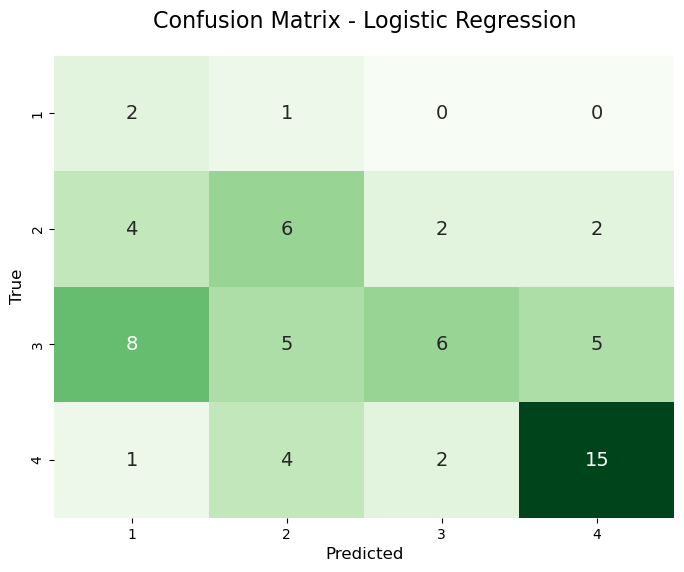

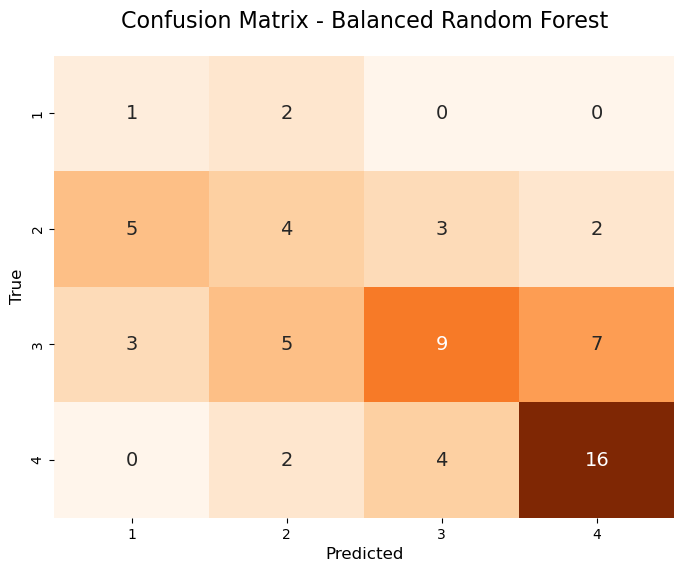

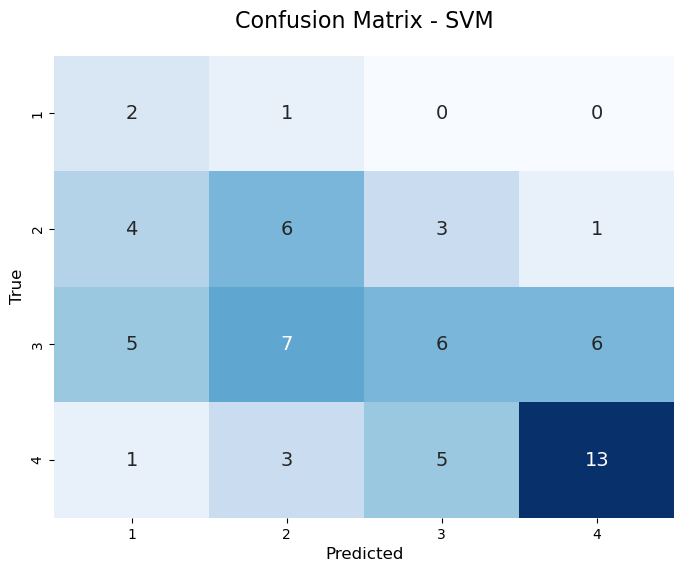

In [10]:
plot_cm(y_bench,bench_pred_lr,'Logistic Regression', 'Greens', '../figures/03_cm_lr.svg')
plot_cm(y_bench,bench_pred_tree,'Balanced Random Forest', 'Oranges','../figures/03_cm_tree.svg')
plot_cm(y_bench,bench_pred_svm,'SVM','Blues','../figures/03_cm_svm.svg')